# Hierarchical part with jags

In [1]:
#you have to make sure that you have all of these installed
import cProfile
import re
import math
import numpy as np
import scipy as sp
from scipy import stats
from scipy import optimize as opt
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
import time
import numpy.random
import warnings
warnings.filterwarnings('ignore')
import multiprocessing as mp

In [2]:
import chen_utils as ch
import user_simulation_utils as sim

In [3]:
###Generation of people and their characteristics
np.random.seed(123)
# beta predictors
# assume beta (rate parameter) is determined by avg. transaction size
# avg income and whether public transport was used and loyalty programm membership
# create this feature matrix
Std = 0.02
People = 50
mean_transaction = np.random.normal(np.log(15), Std, People)
mean_transaction = np.exp(mean_transaction)

mean_income = np.random.normal(1800, 100, People)

public_transport = [0] * 5 + [1] * 5
public_transport = np.array(public_transport * 5)
# p predictors
# assume p (SOW) is driven by loyalty card membership and whether discounter is present
# create this feature matrix
# membership in loyalty
loyalty = np.random.binomial(1, 0.6, 50)

discounter = np.array([0, 1] * 25)

preference = np.array(stats.uniform.rvs(0, 1, size=People, random_state = 123))

theta_beta = 1 -0.2*mean_transaction + 0.0005*mean_income + 0.5*public_transport + 0.6*loyalty + np.random.normal(0.01, 0.01, People) 
beta = np.exp(theta_beta) 

theta_p = -0.2 +0.4*loyalty - 0.8*discounter + preference + np.random.normal(0.01, 0.01, People)
p = sim.expit(theta_p)

In [4]:
covariates = pd.DataFrame({'mean_transaction': mean_transaction, 'mean_income': mean_income, 'public_transport': public_transport, 'loyalty': loyalty, 'discounter': discounter, 'preference': preference, 'true_beta': beta, 'true_p': p})
covariates

,discounter,loyalty,mean_income,mean_transaction,preference,public_transport,true_beta,true_p
0,0,1,1670.591468,14.677821,0.696469,0,0.620273,0.712686
1,1,1,1696.121179,15.302208,0.286139,0,0.549331,0.424306
2,0,1,1974.371223,15.085134,0.226851,0,0.660819,0.607978
3,1,1,1720.193726,14.554851,0.551315,0,0.642111,0.482259
4,0,1,1802.968323,14.827420,0.719469,0,0.637987,0.716421
5,1,0,1906.931597,15.503704,0.423106,1,0.536961,0.361698
6,0,0,1889.070639,14.289380,0.980764,1,0.666485,0.687262
7,1,1,1975.488618,14.871877,0.684830,1,1.132924,0.523146
8,0,1,1949.564414,15.384629,0.480932,1,1.010449,0.667736
9,1,1,1906.939267,14.742219,0.392118,1,1.125090,0.449210


In [16]:
covariates.to_csv('covariates.csv', sep=',', encoding='utf-8',index=False)

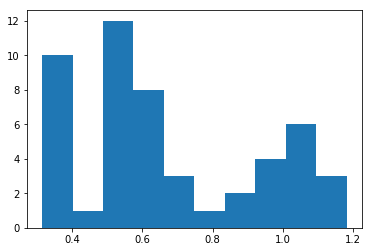

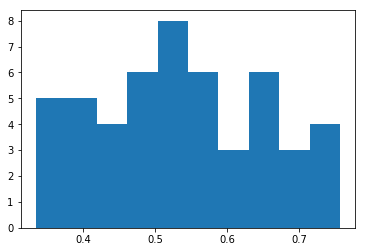

In [5]:
#check distribution of beta and p
plt.hist(beta)
plt.show()

plt.hist(p)
plt.show()

In [6]:
observations = []
for i in range(len(p)):
    observations.append(sim.simulate_data(share_observed = p[i], rate_input = beta[i], observations_total = 20))

In [11]:
observations[0:3]

[[array([ 3.24156099,  1.12649107,  3.70012025,  2.07630375,  4.16234021,
          5.61565658,  2.93417865,  2.67425042,  2.3689876 ,  4.08831374,
          4.23982854,  3.3239371 ,  0.87011614,  0.76376144,  0.76906907,
          1.52036594,  6.27208607,  1.51603128,  0.89894822,  2.94641787]),
  11.576023696977781],
 [array([  5.3673338 ,   8.82421469,   1.73359213,  11.53221115,
          27.6293202 ,   0.84236473,   4.4372128 ,   4.74110039,
           4.21664995,   2.70503091,  28.95329587,   5.22611469,
           3.47633799,   2.33475202,   2.61263672,   0.97215643,
           3.49446773,  20.14209402,  14.17140275,  20.90657653]),
  3.9612540327046806],
 [array([  7.32728681,   5.78793025,   5.85290317,   1.99441669,
           3.03251756,   5.23671393,   6.8630377 ,   4.12729767,
           4.95222119,   2.59299191,   4.57411581,   2.10879076,
           3.58551389,   6.56399142,   7.50652455,   2.34297101,
          10.05935279,   0.9440298 ,   3.3346506 ,   5.56941397]), 0]

In [10]:
npinput = np.asarray(observations)

# delete all last purchase bigger than 30
# check mapping and potentially keep user_id --> check
print("2 parameter model")
pool = mp.Pool(processes = None)
t0 = time.time()
results_2par = pool.map(ch.metropolis_solution_trajectory, npinput)
t1 = time.time()
print(t1-t0)

2 parameter model
174.0055890083313


In [11]:
results_2par

[array([[ 0.40255577,  1.52553595],
        [ 0.40255577,  1.52553595],
        [ 0.40255577,  1.52553595],
        ..., 
        [ 0.35619273,  1.45235829],
        [ 0.35619273,  1.45235829],
        [ 0.35619273,  1.45235829]]), array([[ 0.66971353,  0.32633532],
        [ 0.46073976,  0.40642289],
        [ 0.73087911,  0.28311724],
        ..., 
        [ 0.35081931,  0.6573296 ],
        [ 0.35081931,  0.6573296 ],
        [ 0.33273626,  0.86188497]]), array([[ 0.90850771,  0.4330979 ],
        [ 0.90850771,  0.4330979 ],
        [ 0.90850771,  0.4330979 ],
        ..., 
        [ 0.58829671,  0.64577446],
        [ 0.80053504,  0.70675708],
        [ 0.6387147 ,  0.79419547]]), array([[ 0.91785934,  0.28536742],
        [ 0.91785934,  0.28536742],
        [ 0.91785934,  0.28536742],
        ..., 
        [ 0.37554081,  0.72398683],
        [ 0.31257063,  0.77068647],
        [ 0.31257063,  0.77068647]]), array([[ 0.29385454,  1.53989187],
        [ 0.29385454,  1.53989187],
    

In [19]:
final_results = np.zeros((len(results_2par)*len(results_2par[0]), 2))
final_ids = np.zeros((len(results_2par)*len(results_2par[0]), 1))

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [20]:
for i in range(len(results_2par)):
    for j in range(len(results_2par[i])):
        final_results[i*len(results_2par[i])+j] = [results_2par[i][j][0], results_2par[i][j][1]]
        final_ids[i*len(results_2par[i])+j] = i + 1

In [21]:
final_results

array([[ 0.40255577,  1.52553595],
       [ 0.40255577,  1.52553595],
       [ 0.40255577,  1.52553595],
       ..., 
       [ 0.24875964,  1.72604222],
       [ 0.24875964,  1.72604222],
       [ 0.24875964,  1.72604222]])

In [23]:
df = pd.DataFrame({'user_category_ids': final_ids.ravel(), '2par_first': final_results[:,0].ravel(), '2par_second': final_results[:,1].ravel()})
df

,2par_first,2par_second,user_category_ids
0,0.402556,1.525536,1.0
1,0.402556,1.525536,1.0
2,0.402556,1.525536,1.0
3,0.429925,1.353532,1.0
4,0.559352,1.320975,1.0
5,0.422666,1.127253,1.0
6,0.401054,1.159213,1.0
7,0.609493,1.007621,1.0
8,0.774926,0.816540,1.0
9,0.774926,0.816540,1.0


In [24]:
df.to_csv('metropolis_trajectory.csv', sep=',', encoding='utf-8',index=False)